# <center>Network Science</center>

## <center>Home Assignment #2: Network models</center>

### <center>Student: *Ruslan Kireev*</center>

#### <hr /> General Information

**Due Date:** 28.02.2016 23:59 <br \>
**Late submission policy:** -0.2 points per day <br \>


Please send your reports to <mailto:network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2015] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Problems

### Task 1

Consider Barabasi and Albert dynamical grow model. Two main ingredients of this model are *network growing* and *prefferential attachment*. Implement two restricted B&A-based models:
<br \>

**Model A**
<br \>
Lack of prefferential attachment, that is at each time-step form edges uniformly at random while network keeps growing.

**Model B**
<br \>
Lack of growing, that is fix total number of nodes, on each time-step randomly choose one and form edges with prefferential attachment.
<br \>

1. Generate networks according to the models above ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
4. Is scale-free property conserved in these models?

Analyse results with respect to various parameter settings

--------------------------------------------
Here is some libs import and functions described:

    random_subset(seq,m): Return m unique elements from seq. This differs from random.sample which can return repeated elements if seq holds repeated elements. (from networkx lib)

    av_path_length(G): Return average path length of G, ignoring disconnectivity of a graph, unlike networkx

Time is set to 10000 but it may vary in some cases

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
%matplotlib inline

T = 10000         

def random_subset(seq,m):
    targets=set()
    while len(targets)<m:
        x=random.choice(seq)
        targets.add(x)
    return targets

def av_path_length(G):
    for i in G.nodes():
        if G.degree(i)==0:
            G.remove_node(i)
    length = 0
    n = len(G.nodes())
    for a in G.nodes():
        for b in G.nodes():
            try:
                length+=nx.shortest_path_length(G,source=a,target=b)
            except:
                pass
    return 1.0*length/n/(n-1)

 The probability of a new node connecting to any pre-existing node is equal. The resulting degree distribution in this limit is geometric, indicating that growth alone is not sufficient to produce a scale-free structure.
 Well in loglog scale it doesn't looks like a line. To prove that it's not a scale free distribution, let's generate few with a different number of nodes. 
 Also number of new edges were set equal to $10$

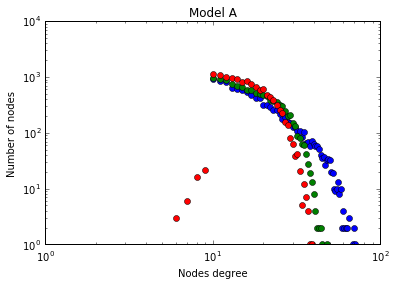

In [63]:
for n0 in range(100, 3001, 1000):
    m = 10
    G=nx.empty_graph(n0)
    for t in xrange(1,T):
        new_links = random.sample(G.nodes(),m)
        G.add_node(n0)
        G.add_edges_from(zip([n0]*m,new_links))
        n0 = G.number_of_nodes()
    plt.loglog(nx.degree_histogram(G),'o')    
plt.ylabel('Number of nodes')
plt.xlabel('Nodes degree')
plt.title('Model A')

As it can be seen from this picture above, distribution differs with number of nodes, so it's not a scale free.

For model b $m$ also was set 10 and $n=1000$. The model begins with a fixed number of disconnected nodes and adds links, preferentially choosing high degree nodes as link destinations. Though the degree distribution early in the simulation looks scale-free, the distribution is not stable, and it eventually becomes nearly Gaussian as the network nears saturation. So preferential attachment alone is not sufficient to produce a scale-free structure.

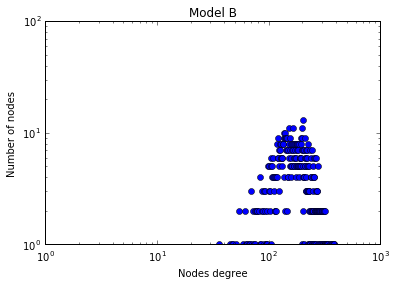

In [82]:
av_node_degree = []
def modelB(n0):
    m = 10
    G=nx.empty_graph(n0)
    repeated_nodes=range(n0)
    for t in xrange(1,T):
        av_node_degree.append(np.mean(np.array(G.degree(G.nodes()).values())))
        new_links = random_subset(repeated_nodes,m)
        selected_node = random.randint(0,n0-1)
        G.add_edges_from(zip([selected_node]*m,new_links))
        repeated_nodes.extend(new_links)
        repeated_nodes.extend([selected_node]*m)
    return G

degrees = np.array(nx.degree_histogram(modelB(1000)))
plt.loglog(degrees, 'o') 
plt.ylabel('Number of nodes')
plt.xlabel('Nodes degree')
plt.title('Model B')

Clearly it's not a scale free, according the picture it doesn't have power law distribution.

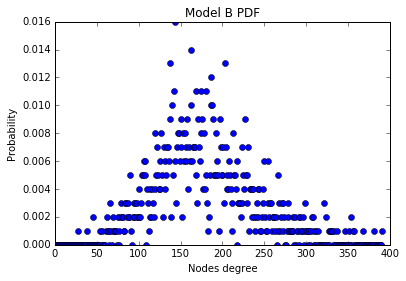

In [65]:
pdf = 1.0*degrees/np.sum(degrees)
plt.plot(pdf, 'o')
plt.ylabel('Probability')
plt.xlabel('Nodes degree')
plt.title('Model B PDF')

If we vary the time $T$ from small values to 10000 we can notice how the pick on the pdf graph moves to right from left side. So in the beginning it looks a bit powerish distributed, but in time it becomes rather gaussian.

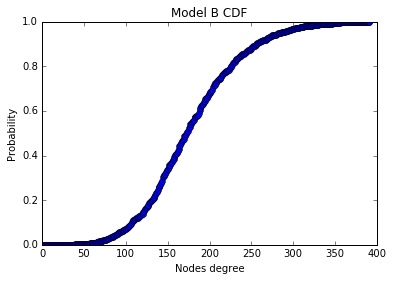

In [66]:
cdf = np.zeros(pdf.shape[0])
curr_sum = 0
for i in range(pdf.shape[0]):
    cdf[i] = curr_sum
    curr_sum += pdf[i]

plt.plot(cdf, 'o')
plt.ylabel('Probability')
plt.xlabel('Nodes degree')
plt.title('Model B CDF')

Let's calculate dependancies to number of nodes and compare to Barabási–Albert model (the green dots).

In [67]:
N = range(1000,5001,500)
BA_model_clustering = np.power(np.array(N),-0.75)
BA_model_path = np.log(np.array(N))/np.log(np.array(np.log(np.array(N))))
average_path_length = []
average_clustering = []
for n in N:
    G = modelB(n)
    average_path_length.append(av_path_length(G))
    average_clustering.append(nx.average_clustering(G))

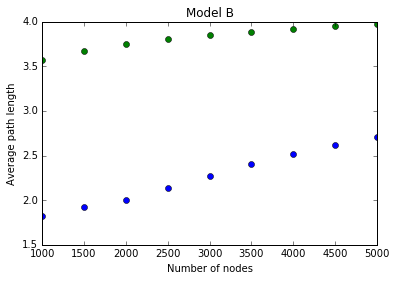

In [68]:
plt.plot(N, average_path_length, 'o')
plt.plot(N, BA_model_path, 'o')
plt.ylabel('Average path length')
plt.xlabel('Number of nodes')
plt.title('Model B')

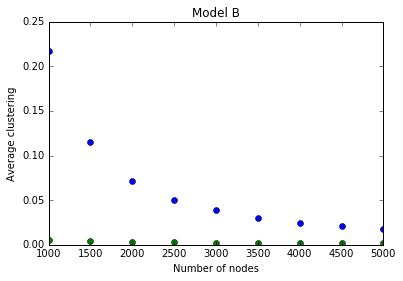

In [69]:
plt.plot(N, average_clustering, 'o')
plt.plot(N, BA_model_clustering, 'o')
plt.ylabel('Average clustering')
plt.xlabel('Number of nodes')
plt.title('Model B')

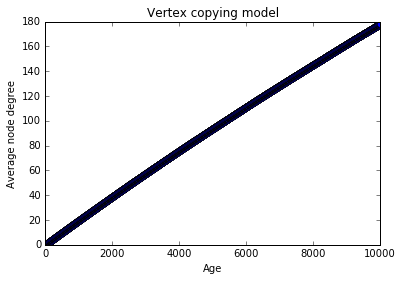

In [83]:
plt.plot(av_node_degree, 'o')
plt.ylabel('Average node degree')
plt.xlabel('Age')
plt.title('Vertex copying model')

As it was shown these two models is not scale free. Only together it is.

### <hr /> Task 2

Consider the following  "Vertex copying model" of growing network.

At every time step a random vertex from already existing vertices is selected and duplicated together with all edges, such that  every edge of the  vertex
* is copied with probability $q$
* is rewired to any other randomly selected vertex with probability $1-q$


Starting state is defined by some small number of randomly connected vertices.

The model can generate both directed and undirected networks.

1. Generate  graphs based on the model ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
    
Analyse results with respect to various parameter settings

----
The vertex copying mechanism will tend to produce a “rich get richer” effect, as vertices with many connections to them have a higher probability that one of their neighbors will be chosen for copying, and when such an event occurs, their degree will increase.

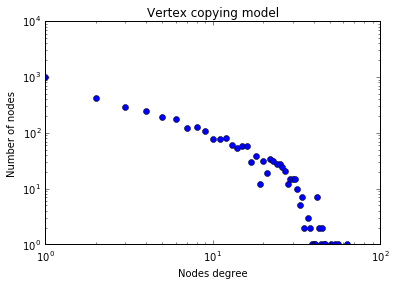

In [80]:
av_node_degree = []
def task2(n0, q):
    G=nx.gnm_random_graph(n0, int(0.1*n0))
    for t in xrange(1,T):
        av_node_degree.append(np.mean(np.array(G.degree(G.nodes()).values())))
        selected_node = random.randint(0,n0-1)
        G.add_node(n0)
        for a in G.neighbors(selected_node):
            if q>random.random():
                G.add_edge(n0,a)
            else:
                G.add_edge(n0,random.randint(0,n0-1))
        n0+=1
    return G

degrees = np.array(nx.degree_histogram(task2(1000,0.9)))
plt.loglog(degrees, 'o') 
plt.ylabel('Number of nodes')
plt.xlabel('Nodes degree')
plt.title('Vertex copying model')

It looks like a power law!

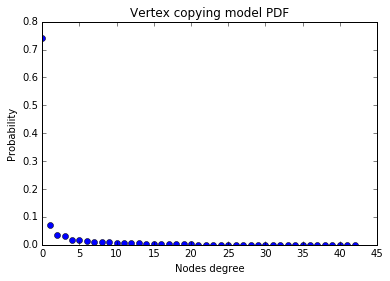

In [72]:
pdf = 1.0*degrees/np.sum(degrees)
plt.plot(pdf, 'o')
plt.ylabel('Probability')
plt.xlabel('Nodes degree')
plt.title('Vertex copying model PDF')

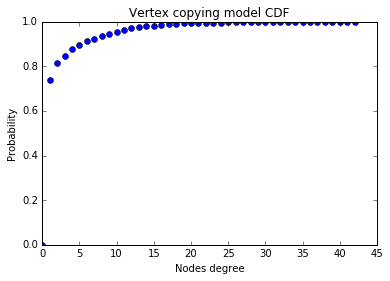

In [73]:
cdf = np.zeros(pdf.shape[0])
curr_sum = 0
for i in range(pdf.shape[0]):
    cdf[i] = curr_sum
    curr_sum += pdf[i]

plt.plot(cdf, 'o')
plt.ylabel('Probability')
plt.xlabel('Nodes degree')
plt.title('Vertex copying model CDF')

PDF and CDF confirm the model to has a power law distribution.

In [74]:
N = range(1000,5001,500)
average_path_length = []
average_clustering = []
T = 100
for n in N:
    G = task2(n,0.9)
    average_path_length.append(av_path_length(G))
    average_clustering.append(nx.average_clustering(G))

Let's illustrate Average path length, Average clustering and Average node degree. $T$ was decreased due to computational time.

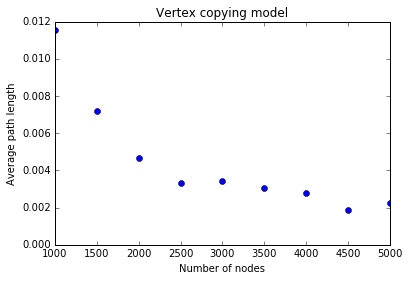

In [75]:
plt.plot(N, average_path_length, 'o')
plt.ylabel('Average path length')
plt.xlabel('Number of nodes')
plt.title('Vertex copying model')

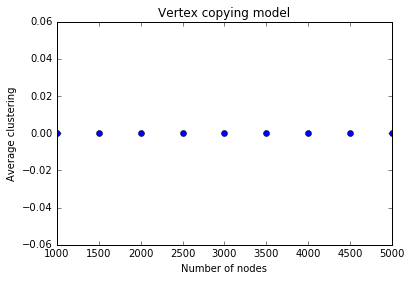

In [76]:
plt.plot(N, average_clustering, 'o')
plt.ylabel('Average clustering')
plt.xlabel('Number of nodes')
plt.title('Vertex copying model')

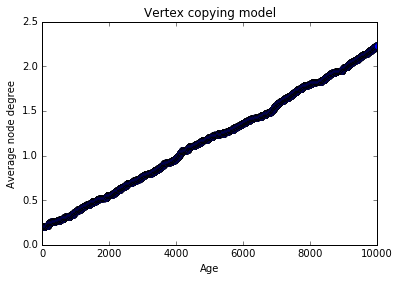

In [81]:
plt.plot(av_node_degree, 'o')
plt.ylabel('Average node degree')
plt.xlabel('Age')
plt.title('Vertex copying model')

I tried to vary $q$, the less it is the more the model distribution looks like model A. So I picked up $q=0.9$ to give most line-like in loglog scale distribution.